In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib notebook
import seaborn as sns
import shapefile as shp
import pyproj
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import box
from shapely.geometry.polygon import Polygon
import mapclassify as mc
from scipy.spatial import distance
from scipy import ndimage
import geopandas as gpd
from shapely.geometry import shape, Point, Polygon
import csv
import os
import importlib
from pulp import *
import math
import scripts.neighbors as neigh #scripts.
importlib.reload(neigh)
import copy


In [25]:
desired_width = 320
pd.set_option('display.width', desired_width)
np.set_printoptions(linewidth=desired_width)
pd.set_option('display.max_columns', 10)

In [26]:
#locate madrid traffic data
data_path = os.getcwd()+'\\csv_files\\traffic_points.csv'
data = pd.read_csv(data_path)
raw_traffic_df = pd.DataFrame(data=data)

In [27]:
#load poi
gp_poi=shp.Reader(os.getcwd()+'\shapefiles\gis_osm_pois_free_1.shp')

In [28]:
def point_df_to_gdf(df):
    """takes a dataframe with columns named 'longitude' and 'latitude'
    to transform to a geodataframe with point features"""

    df['coordinates'] = df[['longitud', 'latitud']].values.tolist()
    df['coordinates'] = df['coordinates'].apply(Point)
    df = gpd.GeoDataFrame(df, geometry='coordinates')
    return df
    
def polygon_df_to_gdf(df):
    """takes a dataframe with columns named 'longitude' and 'latitude'
    to transform to a geodataframe with point features"""
    geometry = [box(x1, y1, x2, y2) for x1,y1,x2,y2 in zip(df.left, df.bottom, df.right, df.top)]
    df = df.drop(['left', 'bottom', 'right', 'top'], axis=1)
    geodf = gpd.GeoDataFrame(df, geometry=geometry)
    return df

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords'
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    records = [y[:] for y in sf.records()]
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

In [29]:
traffic_points_gdf = point_df_to_gdf(raw_traffic_df)

In [30]:
traffic_points_gdf.to_file(os.getcwd()+'\\shapefiles\\traffic_points.shp')

<ipython-input-30-396a54aaab16>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  traffic_points_gdf.to_file(os.getcwd()+'\\shapefiles\\traffic_points.shp')


In [31]:
#shp_charg_stat = shp.Reader(os.getcwd()+'\\shapefiles\\charging_stations.shp')
shp_charg_stat = shp.Reader(os.getcwd()+'\\shapefiles\\EV_points.shp')
#print(shp_charg_stat.records())

In [32]:
shp_path_roads_1 = os.getcwd()+'\\shapefiles\\gis_osm_roads_free_1.shp'
sf_roads_1 = shp.Reader(shp_path_roads_1)
df_roads = read_shapefile(sf_roads_1)
df_roads['coords'] = df_roads['coords'].apply(LineString)
df_roads = gpd.GeoDataFrame(df_roads, geometry='coords')

In [33]:
df_charg_stat = read_shapefile(shp_charg_stat)
df_charg_stat['longitud']=[df_charg_stat['coords'][i][0][0] for i in range(len(df_charg_stat))]
df_charg_stat['latitud']=[df_charg_stat['coords'][i][0][1] for i in range(len(df_charg_stat))]
drop_columns = ['coords']
df_charg_stat = df_charg_stat.drop(labels=drop_columns, axis=1)

In [34]:
existing_chargers_gdf = point_df_to_gdf(df_charg_stat)
existing_chargers_gdf.to_file(os.getcwd()+'\\shapefiles\\existing_chargers.shp')

<ipython-input-34-bd3054745001>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  existing_chargers_gdf.to_file(os.getcwd()+'\\shapefiles\\existing_chargers.shp')


In [35]:
y_lim = (40.3,40.58)                                    # y coordinates (boundaries of city of Manchester)
x_lim = (-3.85,-3.55)                                    # x coordinates (boundaries of city of Manchester)
x1_y1 = (-2.2648971967997866,53.437999025519474)             # latitudes (boundaries of city of Manchester)
x2_y2 = (-2.1597774081293526,53.5055991531199)            # longitudes (boundaries of city of Manchester)

In [36]:
rect=Polygon([(x_lim[0],y_lim[0]),(x_lim[0],y_lim[1]),(x_lim[1],y_lim[1]),(x_lim[1],y_lim[0]),(x_lim[0],y_lim[0])])
rect_gdf=gpd.GeoDataFrame([1], geometry = [rect], crs=27700)

In [90]:
# Convert poi
poi_df = read_shapefile(gp_poi)
poi_df['longitud']=[poi_df['coords'][i][0][0] for i in range(len(poi_df))]
poi_df['latitud']=[poi_df['coords'][i][0][1] for i in range(len(poi_df))]
poi_gdf = point_df_to_gdf(poi_df)
poi_gdf=poi_gdf.clip(rect)
#poi_gdf = poi_gdf.drop(labels=['name'], axis=1)
#print(poi_gdf)
#coll=['osm_id','code','fclass','coords','longitud','latitud']
coll=['coords']
for col in coll:
    #print(col)
    poi_gdf[col] = poi_gdf[col].astype(str)
poi_gdf.to_file(os.getcwd()+'\\shapefiles\\pois_clip.shp')

            osm_id  code          fclass                                         name                      coords  longitud    latitud                coordinates
0         25913327  2401           hotel                       NH Ciudad de la Imagen  [[-3.7881758, 40.3984408]] -3.788176  40.398441  POINT (-3.78818 40.39844)
1         25931627  2203          cinema                         mk2 Palacio de Hielo  [[-3.6361022, 40.4631411]] -3.636102  40.463141  POINT (-3.63610 40.46314)
2         25931630  2257        ice_rink                                               [[-3.6376566, 40.4630376]] -3.637657  40.463038  POINT (-3.63766 40.46304)
3         26065697  2301      restaurant                               Café Comercial   [[-3.7020018, 40.428732]] -3.702002  40.428732  POINT (-3.70200 40.42873)
4         26065699  2304             pub                          Sidrería la Camocha  [[-3.7016864, 40.4270264]] -3.701686  40.427026  POINT (-3.70169 40.42703)
...            ...   ...    

<ipython-input-90-8010c8d17d6b>:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  poi_gdf.to_file(os.getcwd()+'\\shapefiles\\pois_clip.shp')


In [38]:
traffic_points_clip=traffic_points_gdf.clip(rect)
traffic_points_clip.to_file(os.getcwd()+'\\shapefiles\\traffic_points_clip.shp')

<ipython-input-38-2890c76c6b14>:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  traffic_points_clip.to_file(os.getcwd()+'\\shapefiles\\traffic_points_clip.shp')


In [39]:
gdf_roads_clip=df_roads.clip(rect)
#drop_columns = ['coords']
#gdf_roads_clip = gdf_roads_clip.drop(labels=drop_columns, axis=1)
gdf_roads_clip.to_file(os.getcwd()+'\\shapefiles\\map.shp')

(40.3, 40.58)

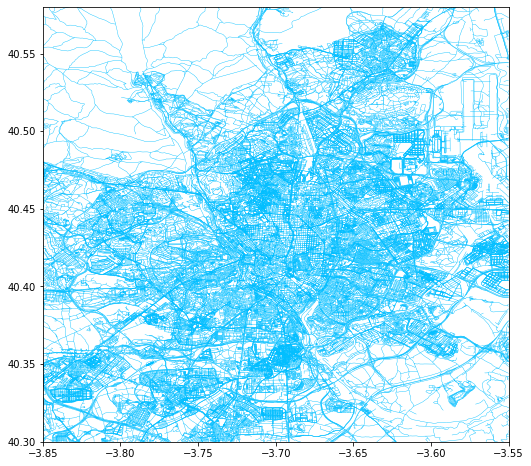

In [40]:
base = gdf_roads_clip.plot(figsize=(12, 8), color='deepskyblue', lw=0.4, zorder=0)  # Zorder controls the layering of the charts with
base.set_xlim(x_lim)
base.set_ylim(y_lim)

<Axes: >

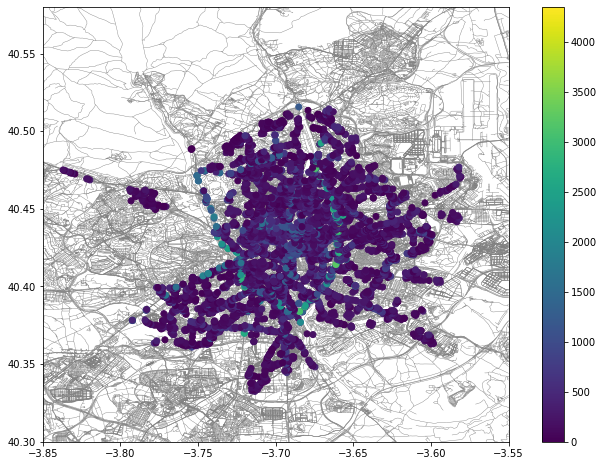

In [41]:
base = gdf_roads_clip.plot(figsize=(12, 8), color='grey', lw=0.4, zorder=0)  # Zorder controls the layering of the charts with
base.set_xlim(x_lim)
base.set_ylim(y_lim)
traffic_points_clip.plot(ax=base,column='x',legend=True)#, cmap='cool')

In [42]:
(poi_gdf['fclass'].unique())     #135

array(['drinking_water', 'artwork', 'kindergarten', 'hotel', 'monument', 'bar', 'pharmacy', 'fountain', 'comms_tower', 'post_box', 'convenience', 'greengrocer', 'cafe', 'bench', 'restaurant', 'bicycle_rental', 'hairdresser', 'supermarket', 'atm', 'bank', 'dentist', 'school', 'fast_food', 'post_office', 'pub',
       'bookshop', 'memorial', 'playground', 'recycling_glass', 'kiosk', 'bicycle_shop', 'furniture_shop', 'community_centre', 'clinic', 'toy_shop', 'recycling', 'beauty_shop', 'general', 'telephone', 'doityourself', 'car_wash', 'biergarten', 'bakery', 'jeweller', 'market_place', 'butcher', 'travel_agent',
       'video_shop', 'college', 'pitch', 'attraction', 'waste_basket', 'sports_centre', 'optician', 'veterinary', 'shoe_shop', 'mobile_phone_shop', 'laundry', 'clothes', 'guesthouse', 'sports_shop', 'stationery', 'department_store', 'recycling_paper', 'observation_tower', 'dog_park', 'cinema', 'recycling_metal',
       'car_dealership', 'water_well', 'camera_surveillance', 'flor

In [43]:
#poi_gdf=poi_gdf.clip(rect)
vec_poi=np.ones(len(poi_gdf))
print(poi_gdf['fclass'][2])
for i in range(len(poi_gdf)):
  if poi_gdf["fclass"].iloc[i]=='bench' or poi_gdf["fclass"].iloc[i]=='camera_surveillance' or poi_gdf["fclass"].iloc[i]=='drinking_water':
    vec_poi[i]=0
  if poi_gdf["fclass"].iloc[i]=='hotel' or poi_gdf["fclass"].iloc[i]=='restaurant' or poi_gdf["fclass"].iloc[i]=='cinema':
    vec_poi[i]=1 
        
#vec_poi=pd.DataFrame(vec_poi.transpose())
print(vec_poi) 

ice_rink
[0. 0. 1. ... 1. 1. 1.]


In [44]:
count_poi = pd.DataFrame(poi_gdf['fclass'].value_counts())
print(count_poi)

                     fclass
restaurant             4343
bench                  4114
camera_surveillance    2591
drinking_water         2160
pharmacy               1941
...                     ...
vending_cigarette         1
chalet                    1
battlefield               1
golf_course               1
theme_park                1

[127 rows x 1 columns]


<Axes: >

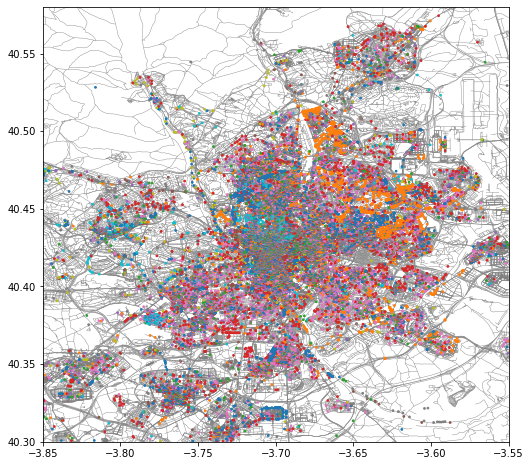

In [45]:
base = gdf_roads_clip.plot(figsize=(12, 8), color='grey', lw=0.4, zorder=0)  # Zorder controls the layering of the charts with
base.set_xlim(x_lim)
base.set_ylim(y_lim)
poi_gdf.plot(ax=base,markersize=3,column='fclass') #,color='red'

<Axes: >

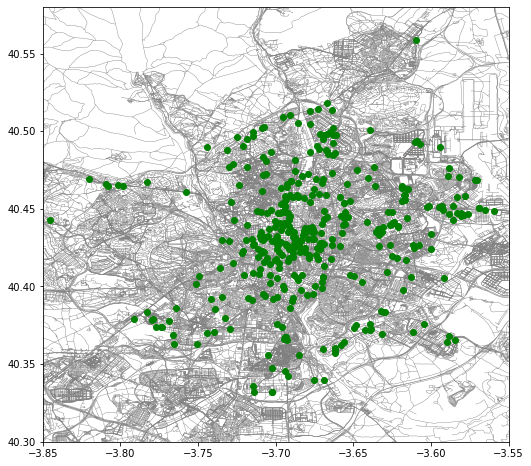

In [46]:
base = gdf_roads_clip.plot(figsize=(12, 8), color='grey', lw=0.4, zorder=0)  # Zorder controls the layering of the charts with
base.set_xlim(x_lim)
base.set_ylim(y_lim)
existing_chargers_gdf.plot(ax=base,color='green')

In [47]:
def exagon(r,y_lim,x_lim):
    xmin =x_lim[0]
    xmax =x_lim[1]
    ymin =y_lim[0]
    ymax =y_lim[1]

    # twice the height of a hexagon's equilateral triangle
    h = (r * math.sqrt(3))

    polygons = []
    tot_traffic_pre=[]
    tot_mixed=[]
    tot_chargers=[]
    tot_centroide_x=[]
    tot_centroide_y=[]
    colore=[]
    rows=0
    cols=0
    # create the hexagons
    for x in np.arange(xmin, xmax, h):
        k=1
        for y in np.arange(ymin, ymax, (h * h / r / 2)):
            if k==0:
                x=x+r * math.sqrt(3)/2
                hexagon = shape(
                    {
                        "type": "Polygon",
                        "coordinates": [
                            [
                                [x, y + r],
                                [x + h / 2, y + r / 2],
                                [x + h / 2, y - r / 2],
                                [x, y - r],
                                [x - h / 2, y - r / 2],
                                [x - h / 2, y + r / 2],
                                [x, y + r],
                            ]
                        ],
                    }
                )
                polygons.append(hexagon)
                centroide_x=x
                centroide_y=y
                x=x-r * math.sqrt(3)/2
                k=1
            elif k==1:
                hexagon = shape(
                    {
                        "type": "Polygon",
                        "coordinates": [
                            [
                                [x, y + r],
                                [x + h / 2, y + r / 2],
                                [x + h / 2, y - r / 2],
                                [x, y - r],
                                [x - h / 2, y - r / 2],
                                [x - h / 2, y + r / 2],
                                [x, y + r],
                            ]
                        ],
                    }
                )
                polygons.append(hexagon)
                k=0
                centroide_x=x
                centroide_y=y
            tot_centroide_x.append(centroide_x)
            tot_centroide_y.append(centroide_y)
            parziale=traffic_points_gdf.clip(hexagon)["x"].sum()
            tot_traffic_pre.append(parziale)
            #mixed=mean_car_count_gdf.clip(hexagon)["mixed_use_area_per_cell"].mean()
            #tot_mixed.append(mixed)
            chargers=existing_chargers_gdf.clip(hexagon)['longitud'].count()
            tot_chargers.append(chargers)
            rows+=1
        cols+=1   
    rows=int(rows/cols)
    tot_traffic = copy.copy(tot_traffic_pre)
    for i in range(len(tot_traffic)):
        if tot_traffic_pre[i]==0:
            v_n = neigh.neighbors(rows,cols,i)[0]
            tot_traffic[i] = np.mean([tot_traffic_pre[int(j)] for j in v_n])
    
    mas=max(tot_traffic)
    for k in range(len(tot_traffic)):
        if tot_traffic[k]<=0.0*mas:
            col='lightcyan'
        elif tot_traffic[k]<=0.15*mas:
            col='lightskyblue'
        elif tot_traffic[k]<=0.4*mas:
            col='deepskyblue'
        elif tot_traffic[k]<=0.6*mas:
            col='royalblue'
        elif tot_traffic[k]<=mas:
            col='darkblue'
        colore.append(col)
    with open('dati.csv', mode='w') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        #scriviamo prima la riga di intestazione
        csv_writer.writerow(['ID', 'Traffico', 'no_existing_chg', 'centroid_x', 'centroid_y', 'Colore']) #,'mixed_use_area_per_cell'
        for k in range(len(tot_chargers)):
            csv_writer.writerow([k,tot_traffic[k],tot_chargers[k],tot_centroide_x[k],tot_centroide_y[k],colore[k]]) #,tot_mixed[k]
    #poly_grid = gpd.GeoDataFrame({'geometry': polygons}) 
    #base = gdf_roads_clip.plot(figsize=(12, 8), color='deepskyblue', lw=0.4, zorder=0)  # Zorder controls the layering of the charts with
    #base.set_xlim(x_lim)
    #base.set_ylim(y_lim)    
    #poly_grid.plot(ax=base, facecolor=colore, edgecolor='black', lw=0.5, zorder=15)
    #poly_grid.to_file(os.getcwd()+'\\shapefiles\\grid_exa.shp')
    return polygons,rows,cols,colore,tot_traffic

In [48]:
#exagon grid
radius = 0.006
polygons,rows,cols,colore,tot_traffic = exagon(radius,y_lim,x_lim)

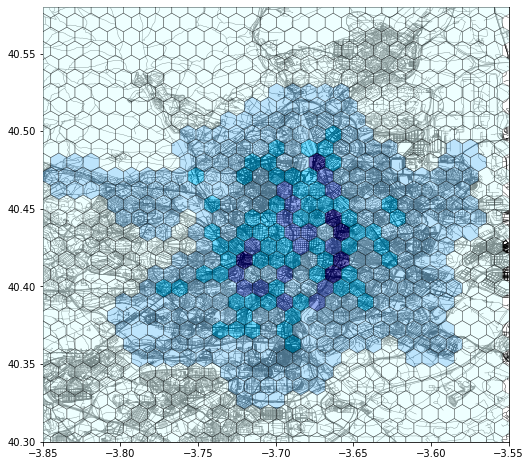

In [49]:
poly_grid = gpd.GeoDataFrame({'geometry': polygons}) 
base = gdf_roads_clip.plot(figsize=(12, 8), color='black', lw=0.4, zorder=0)  # Zorder controls the layering of the charts with
base.set_xlim(x_lim)
base.set_ylim(y_lim)    
poly_grid.plot(ax=base, facecolor=colore, edgecolor='black', lw=0.5, zorder=15,alpha=0.55)
#poly_grid.plot(ax=base, facecolor='#999999', edgecolor='black', lw=0.5, zorder=15)
poly_grid.to_file(os.getcwd()+'\\shapefiles\\grid_exa.shp')

In [50]:
traffic_points = gpd.read_file(os.getcwd()+'\\shapefiles\\traffic_points.shp')
polys = gpd.read_file(os.getcwd()+'\\shapefiles\\grid_exa.shp')
points_polys = gpd.sjoin(traffic_points, polys, how="right")

### Optimisation.py

In [51]:
# Import GIS data and car park location data
GIS_data = pd.read_csv(os.getcwd()+'\\dati.csv')
GIS_df = pd.DataFrame(GIS_data)
#GIS_df['mixed_use_area_per_cell']=GIS_df['mixed_use_area_per_cell'].fillna(0)

car_park_data = GIS_df.iloc[:,[0,3,4]]
car_park_df = pd.DataFrame(car_park_data)

In [52]:
def gen_sets(df_demand, df_parking):
    """Generate sets to use in the optimization problem"""
    # set of charging demand locations (destinations)
    demand_lc = df_demand.index.tolist()
    # set of candidates for charging station locations (currently existing parking lots)
    chg_lc = df_parking.index.tolist()
    return demand_lc, chg_lc

In [53]:
def gen_parameters(df_demand, df_parking):
    """Generate parameters to use in the optimization problem,
    including cost to install charging stations, operating costs and others..."""

    N = 10                               # Where vi is the charging possibility of an EV in cell i
    fi = df_demand["Traffico"]          # Where fi is the average traffic flow in grid i
    di = fi                      # Where di represents the charging demand of EV in grid i
    #di = di.to_dict()

    # distance matrix of charging station location candidates and charging demand location
    coords_parking = [(x, y) for x, y in zip(df_parking['centroid_x'], df_parking['centroid_y'])]

    coords_demand = [(x, y) for x, y in zip(df_demand['centroid_x'], df_demand['centroid_y'])]

    distance_matrix = distance.cdist(coords_parking, coords_demand, 'euclidean')
    scaling_ratio = 1
    distance_matrix2 = scaling_ratio * distance_matrix
    distance_matrix3 = pd.DataFrame(distance_matrix2, index=df_parking.index.tolist(),
                                    columns=df_demand.index.tolist())
                                    
    #poi_df = qge.read_shapefile(gp_poi)
    coords_pois = [(x, y) for x, y in zip(poi_gdf['longitud'], poi_gdf['latitud'])]
    distance_matrix_poi = distance.cdist(coords_parking, coords_pois, 'euclidean')
    distance_matrix_poi = pd.DataFrame(distance_matrix_poi, index=df_parking.index.tolist())
    distance_poi = (distance_matrix_poi * vec_poi).sum()
    print('distance_poi')
    print(distance_poi)
    max = np.max(distance_poi)
    min = np.min(distance_poi)
    d_poi_scale = (distance_poi - min)/(max - min) 
    plt.hist(d_poi_scale)
    #plt.show()
    #print(distance_poi.head())
    return di, N, distance_matrix3, d_poi_scale

In [54]:
def gen_demand(df_demand):
    """generate the current demand for charging for each cell i"""

    diz = df_demand["no_existing_chg"]  # Number of existing chargers in cell i
    #diz = diz.to_dict()

    return diz

In [73]:
def optimize(df_demand, df_parking):

    # Import i and j set function
    demand_lc, chg_lc = gen_sets(df_demand, df_parking)

    # Import parameters function
    di, N, distance_matrix, d_poi_scale = gen_parameters(df_demand, df_parking)

    # Import current demand of car park z in cell i
    diz = gen_demand(df_demand)

    # set up the optimization problem
    prob = LpProblem('FacilityLocation', LpMaximize)

    x = LpVariable.dicts("UseLocation", [j for j in chg_lc], 0, 1, LpBinary)

    r = np.full([len(demand_lc), len(chg_lc)], None)

    # Create empty dictionary for the remaining demand in cell i
    zip_iterator = zip(demand_lc, [None]*len(demand_lc))
    dr = dict(zip_iterator)

    #print(di)
    #print(diz)
    max_d = np.max(di)
    min_d = np.min(di)
    di_scale = (di - min_d)/(max_d - min_d) 
    max_dz = np.max(diz)
    min_dz = np.min(diz)
    diz_scale = (diz - min_dz)/(max_dz - min_dz) 
    di_scale = di_scale.to_dict()
    diz_scale = diz_scale.to_dict()
    # For each cell i subtract the existing number of charging stations from the charging demands in cell i
    for i in demand_lc:
        for j in chg_lc:
            dr[i] = di_scale[i] - diz_scale[i] 
            if dr[i] < 0:       # Can't have negative demand therefore limit minimum demand to zero
                dr[i] = 0

    # Objective function
    # The scaled distance from the POI is considered as a multiplication factor
    lam = 1
    prob += lpSum((dr[j]*x[j])*(1-lam*d_poi_scale[j]) for j in chg_lc) #

    # Constraints
    prob += lpSum(x[j] for j in chg_lc) == N                            # Constraint 6

    prob.solve()
    print("Status: ", LpStatus[prob.status])
    #print([x[j].varValue for j in range(len(x))])
    tolerance = .9
    opt_location = []
    for j in chg_lc:
        if x[j].varValue > tolerance:   # If binary value x is positive then the car park has been selected
            opt_location.append(j)
            print("Establish charging station at parking lot", j)
    df_status = pd.DataFrame({"status": [LpStatus[prob.status]], "Tot_no_chargers": [len(opt_location)]})
    print("Final Optimisation Status:\n", df_status)
    
    #print(len(chg_lc))
    #print(len(demand_lc))

    #print(prob.variables())
    varDic = {}
    for variable in prob.variables():
        var = variable.name
        if var[:5] == 'no_of':      # Filter to obtain only the variable 'no_of_chgrs_station_j'
            varDic[var] = variable.varValue

    #print(varDic)
    for variable in prob.variables():
        var = variable.name
#         print(var)
#         print(variable.varValue)

    var_df = pd.DataFrame.from_dict(varDic, orient='index', columns=['value'])
    # Sort the results numerically
    sorted_df = var_df.index.to_series().str.rsplit('_').str[-1].astype(int).sort_values()
    var_df = var_df.reindex(index=sorted_df.index)
    var_df.reset_index(inplace=True)

    location_df = pd.DataFrame(opt_location, columns=['opt_car_park_id'])
#     print(location_df.head())
#     print(car_park_df.head())
    opt_loc_df = pd.merge(location_df, car_park_df, left_on='opt_car_park_id',  right_index=True, how='left')
    opt_loc_df2 = pd.merge(opt_loc_df, var_df, left_on='opt_car_park_id',  right_index=True, how='left')
#     opt_loc_df2.to_csv(path_or_buf='optimal_locations.csv')
    
    v1tot=[]
    v2tot=[]
    for i in opt_location:
        v=neigh.neighbors(rows,cols,i)
        v1tot = v1tot + v[0]
        v2tot = v2tot + v[1]

    v2tot = [int(x) for x in v2tot] 
    v1tot = [int(x) for x in v1tot] 
    opt_location = [int(x) for x in opt_location] 
    color = pd.DataFrame(['white']*len(df_parking)).transpose()
    color[v2tot] = 'yellow'
    color[v1tot] = 'orange'
    color[opt_location] = 'red'
    pol2=[polygons[i] for i in v2tot]
    poly_grid2 = gpd.GeoDataFrame({'geometry': pol2})
    poly_grid2.to_file(os.getcwd()+'\\shapefiles\\exa_2.shp')
    pol1=[polygons[i] for i in v1tot]
    poly_grid1 = gpd.GeoDataFrame({'geometry': pol1})
    poly_grid1.to_file(os.getcwd()+'\\shapefiles\\exa_1.shp')
    optpol=[polygons[i] for i in opt_location]
    poly_grid_opt = gpd.GeoDataFrame({'geometry': optpol})
    poly_grid_opt.to_file(os.getcwd()+'\\shapefiles\\exa_opt.shp')
    
    print('Done')
    return opt_location, df_status, opt_loc_df, opt_loc_df2, color


distance_poi
0          0.000000
1          0.000000
2        159.395806
3        158.326778
4        158.861242
            ...    
38428      0.000000
38429    146.705507
38430    145.076068
38431    144.988230
38432    145.561668
Length: 38433, dtype: float64
distance_poi
0          0.000000
1          0.000000
2        159.395806
3        158.326778
4        158.861242
            ...    
38428      0.000000
38429    146.705507
38430    145.076068
38431    144.988230
38432    145.561668
Length: 38433, dtype: float64
Status:  Optimal
Establish charging station at parking lot 394
Establish charging station at parking lot 432
Establish charging station at parking lot 469
Establish charging station at parking lot 564
Establish charging station at parking lot 587
Establish charging station at parking lot 588
Establish charging station at parking lot 589
Establish charging station at parking lot 590
Establish charging station at parking lot 591
Establish charging station at parking lot 5

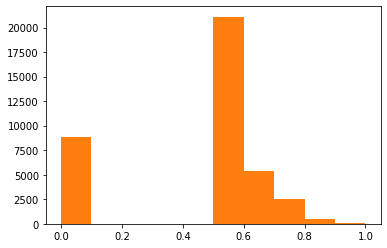

In [74]:
gen_sets(GIS_df,car_park_df)
gen_parameters(GIS_df,car_park_df)
gen_demand(GIS_df)
opt_loc, stat, opt_loc_df, opt_loc_df2, color_opt = optimize(GIS_df,car_park_df)
#print(opt_loc_df)

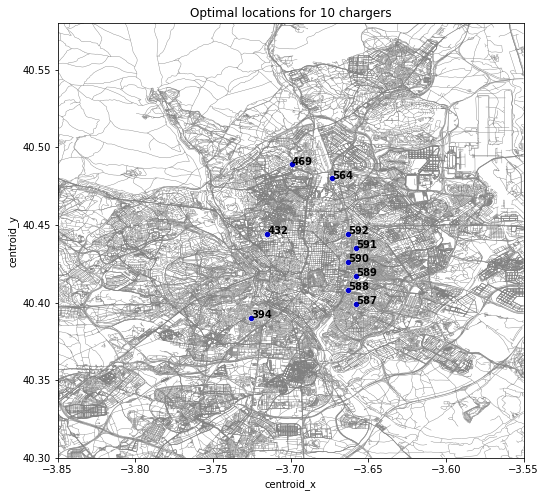

10


In [107]:
base = gdf_roads_clip.plot(figsize=(12, 8), color='grey', lw=0.4, zorder=0)
plot = sns.scatterplot(ax=base, x=opt_loc_df['centroid_x'], y=opt_loc_df['centroid_y'], color='mediumblue', legend='full')
plot.set_xlim(x_lim[0], x_lim[1])
plot.set_ylim(y_lim[0], y_lim[1])
plot.set_title(f'Optimal locations for {len(opt_loc)} chargers')

for line in range(opt_loc_df2.shape[0]):
    plot.text(opt_loc_df2.centroid_x[line], opt_loc_df2.centroid_y[line],
                opt_loc_df2.ID[line], horizontalalignment='left',
                size='medium', color='black', weight='semibold')
plt.show()

In [70]:
col_opt = (color_opt).values.tolist()[0]

<Axes: >

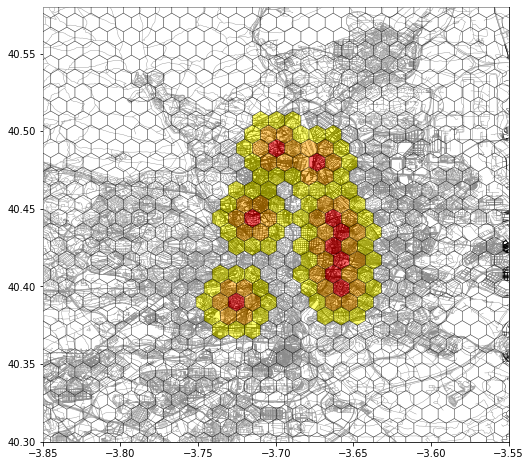

In [71]:
base = gdf_roads_clip.plot(figsize=(12, 8), color='black', lw=0.4, zorder=0)  # Zorder controls the layering of the charts with
base.set_xlim(x_lim)
base.set_ylim(y_lim)    
poly_grid.plot(ax=base, facecolor=col_opt, edgecolor='black', lw=0.5, zorder=15,alpha=0.55)

In [72]:
opt_locations=car_park_df.iloc[opt_loc]
print(opt_locations[['centroid_x', 'centroid_y']])

def point_df_to_gdf2(df):
    """takes a dataframe with columns named 'longitude' and 'latitude'
    to transform to a geodataframe with point features"""

    df['coordinates'] = df[['centroid_x', 'centroid_y']].values.tolist()
    df['coordinates'] = df['coordinates'].apply(Point)
    df = gpd.GeoDataFrame(df, geometry='coordinates')
    return df
    
    
opt_loc_gdf = point_df_to_gdf2(opt_locations)
opt_loc_gdf.to_file(os.getcwd()+'\\shapefiles\\opt_loc_exa.shp')

     centroid_x  centroid_y
394   -3.725292      40.390
432   -3.714900      40.444
469   -3.699312      40.489
564   -3.673331      40.480
587   -3.657742      40.399
588   -3.662939      40.408
589   -3.657742      40.417
590   -3.662939      40.426
591   -3.657742      40.435
592   -3.662939      40.444


<ipython-input-72-0c6cfc4f3dc9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coordinates'] = df[['centroid_x', 'centroid_y']].values.tolist()
<ipython-input-72-0c6cfc4f3dc9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['coordinates'] = df['coordinates'].apply(Point)
<ipython-input-72-0c6cfc4f3dc9>:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  opt_loc_gdf.to_file(os.getcwd()+'\\shapefiles\\opt_loc_exa.shp')


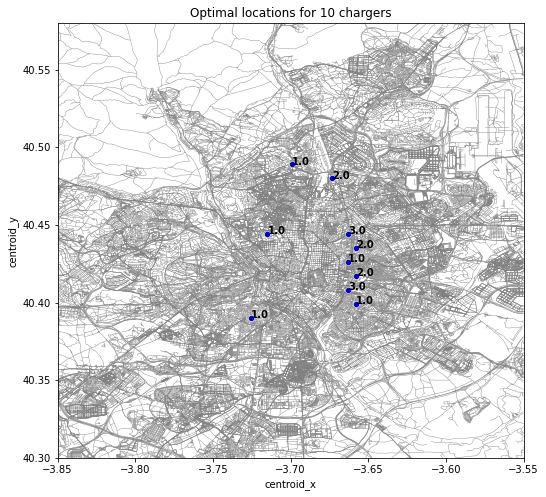

In [125]:
# parameter for sizing
pen_rate=0.1 #penetration rate
ut_rate=0.025 #utilization rate (definied as the number of EV that stops for a charge)
wrk_hours=12 #working hours
crg_rate=90 #charging rate in kW
avg_bat=50 #average battery capacity of a EV in kWh
avg_crg=0.5 #average carging percentage of each session
avg_cap=avg_bat*avg_crg #average carging capacoty needed in a charging session

#sizing 

i=0
num_col=np.zeros(len(opt_loc))
for k in opt_loc:
    num_col[i]=math.ceil(GIS_df['Traffico'][k]*pen_rate*ut_rate*avg_cap/wrk_hours/crg_rate)
    i=i+1

base = gdf_roads_clip.plot(figsize=(12, 8), color='grey', lw=0.4, zorder=0)
plot = sns.scatterplot(ax=base, x=opt_loc_df['centroid_x'], y=opt_loc_df['centroid_y'], color='mediumblue', legend='full')
plot.set_xlim(x_lim[0], x_lim[1])
plot.set_ylim(y_lim[0], y_lim[1])
plot.set_title(f'Optimal locations for {len(opt_loc)} chargers')

for line in range(opt_loc_df2.shape[0]):
    plot.text(opt_loc_df2.centroid_x[line], opt_loc_df2.centroid_y[line],
                num_col[line], horizontalalignment='left',
                size='medium', color='black', weight='semibold')
plt.show()

In [180]:
# ROI
init_cost= 50000 # deployment cost per each station in €
ene_cost= 0.20 # cost of electric energy €/kWh
ene_reve= 0.35 # revenue for electric energy €/kWh


#sizing 

i=0
daily_rev=np.zeros(len(opt_loc))
brk=np.zeros(len(opt_loc))
roi=np.zeros(len(opt_loc))
years=3 #years for the roi

for k in opt_loc:
    daily_rev[i]=(ene_reve-ene_cost)*GIS_df['Traffico'][k]*pen_rate*ut_rate*avg_cap
    brk[i]=math.ceil((init_cost*num_col[i]/daily_rev[i]))
    roi[i]=100*((years*365*daily_rev[i])-(init_cost*num_col[i]))/(init_cost*num_col[i])
    i=i+1
print(brk)
print(roi)
min_brk = min(brk)
min_brk_index = np.where(brk == min_brk)
j=min_brk_index[0].tolist()
print(opt_loc[j[0]])
#print(GIS_df['ID'][opt_loc[j[0]]])
print("The best charging station is at parking lot", opt_loc[j[0]])
print("The breakeven point is at", min_brk , 'days')
print("The expected return of investment after",years,"years is",math.ceil(roi[j]),'%')

[567. 744. 505. 417. 411. 420. 321. 311. 342. 377.]
[ 93.24580439  47.30075747 117.01107551 162.70431346 166.77593767 161.07541753 241.78426341 252.63312618 220.66982744 190.98828279]
590
The best charging station is at parking lot 590
The breakeven point is at 311.0 days
The expected return of investment after 3 years is 253 %
